# Loading Dataset from Buckets

In [0]:
# Loading dataset from Google Buckets (proobj)
!gsutil -m cp -r gs://proobj/t*.zip .
!unzip test.zip
!unzip train.zip

Copying gs://proobj/test.zip...
Copying gs://proobj/train.zip...
| [2/2 files][  1.7 GiB/  1.7 GiB] 100% Done  60.3 MiB/s ETA 00:00:00           
Operation completed over 2 objects/1.7 GiB.                                      
Archive:  test.zip
   creating: test/
  inflating: test/c0461776c.png      
  inflating: test/4bbfd1e05.png      
  inflating: test/1d0cbd819.png      
  inflating: test/93079d970.png      
  inflating: test/856f2910a.png      
  inflating: test/976e4e079.png      
  inflating: test/b31292706.png      
  inflating: test/29bab7cad.png      
  inflating: test/37297a64c.png      
  inflating: test/f2dc546ca.png      
  inflating: test/b6a3f7876.png      
  inflating: test/8874bba69.png      
  inflating: test/1459e96a0.png      
  inflating: test/9a3f20121.png      
  inflating: test/5315c2dca.png      
  inflating: test/b7a7f6390.png      
  inflating: test/20e562fd5.png      
  inflating: test/e3f50adfc.png      
  inflating: test/6ba4ef411.png      
  inflating:

# Loading Libraries and Tranformations 
## Data Preprocessing

In [0]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns


TRAin_DATA_FOLDER= "train"


images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAin_DATA_FOLDER):
    class_folder_path = os.path.join(TRAin_DATA_FOLDER, class_folder_name)
    class_label = class_folder_name
   
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missig value ignore it
          missing += 1
          continue
        images.append(image_bgr)
       
        classes.append(class_label)

In [0]:
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  #res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return img

#save resized images into images.
images = [resize_images(img) for img in images]
images[0].shape

(214, 214, 3)

In [0]:
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res

#save resized images into images.
images = [resize_images(img) for img in images]
images[0].shape

(256, 256, 3)

In [0]:
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)
#for key,value in images_per_class.items():
   # print("number of {0} images is  -> {1}".format(key, len(value)))
  
for label in set(classes):

  print("number of {} images is  -> {}".format(
        label, 
        len(images[classes == label])))

images shape:  (4750, 256, 256, 3)
classes shape:  (4750,)
number of Scentless Mayweed images is  -> 516
number of Common wheat images is  -> 221
number of Common Chickweed images is  -> 611
number of Maize images is  -> 221
number of Fat Hen images is  -> 475
number of Sugar beet images is  -> 385
number of Charlock images is  -> 390
number of Black-grass images is  -> 263
number of Cleavers images is  -> 287
number of Small-flowered Cranesbill images is  -> 496
number of Shepherds Purse images is  -> 231
number of Loose Silky-bent images is  -> 654


In [0]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(classes)
y[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)
print(len(X_train))
X_train[0].shape
print(len(X_test))

3325
1425


In [0]:
random_seed = 2
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)
print(X_test[0].shape, len(X_test))
print(X_val[0].shape, len(X_val))
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

(256, 256, 3) 712
(256, 256, 3) 713


# VGG 16

In [0]:
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

def vgg16_model(num_classes=None):

    model = VGG16(weights='imagenet', include_top=False,input_shape=(256,256,3))
    model.layers.pop()
    model.layers.pop()
    model.layers.pop()

    model.outputs = [model.layers[-1].output]

    model.layers[-2].outbound_nodes= []
    x=Conv2D(256, kernel_size=(2,2),strides=2)(model.output)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)    
    x=Conv2D(128, kernel_size=(2,2),strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x=Conv2D(128, kernel_size=(2,2),strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x=Flatten()(x)
    x=Dense(num_classes, activation='softmax')(x)

    model=Model(model.input,x)

    for layer in model.layers[:15]:

        layer.trainable = False


    return model

In [0]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score
  

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax




In [0]:
from keras import backend as K
num_classes=12
model = vgg16_model(num_classes)
model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.save('model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [0]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
filepath="./weights.best_{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoints = ModelCheckpoint(filepath, monitor='val_acc', 
                              verbose=1, save_best_only=True, mode='max')
filepath="./weights.last_auto4.hdf5"
checkpoints_full = ModelCheckpoint(filepath, monitor='val_acc', 
                                 verbose=1, save_best_only=False, mode='max')

callbacks_list = [checkpoints, checkpoints_full]

#MODEL
# hist = model.fit_generator(generator.flow(X_train,y_train, batch_size=75), 
#                            epochs=35, validation_data=(X_test, y_test), 
#                            steps_per_epoch=x_train.shape[0], callbacks=callbacks_list)
history = model.fit(X_train,y_train,
          batch_size=64,
          epochs=20,
          verbose=1, shuffle=True, validation_data=(X_val,y_val),callbacks= callbacks_list)

Train on 3325 samples, validate on 713 samples
Epoch 1/20
3325/3325 [==============================] - 49s 15ms/step - loss: 1.3425 - acc: 0.5510 - val_loss: 1.3853 - val_acc: 0.5820

Epoch 00001: val_acc improved from -inf to 0.58205, saving model to ./weights.best_01-0.58.hdf5

Epoch 00001: saving model to ./weights.last_auto4.hdf5
Epoch 2/20
3325/3325 [==============================] - 48s 14ms/step - loss: 0.4658 - acc: 0.8415 - val_loss: 0.6232 - val_acc: 0.7700

Epoch 00002: val_acc improved from 0.58205 to 0.76999, saving model to ./weights.best_02-0.77.hdf5

Epoch 00002: saving model to ./weights.last_auto4.hdf5
Epoch 3/20
3325/3325 [==============================] - 48s 14ms/step - loss: 0.2813 - acc: 0.9035 - val_loss: 0.5201 - val_acc: 0.8233

Epoch 00003: val_acc improved from 0.76999 to 0.82328, saving model to ./weights.best_03-0.82.hdf5

Epoch 00003: saving model to ./weights.last_auto4.hdf5
Epoch 4/20
3325/3325 [==============================] - 48s 14ms/step - loss: 0.

ValueError: ignored

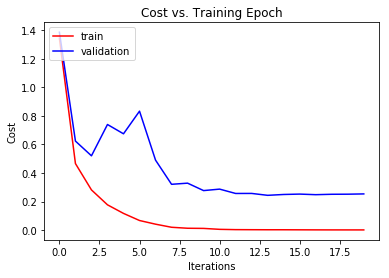

In [0]:
import matplotlib.pyplot as plt
epochs = 20
fig, ax = plt.subplots()  
ax.plot(np.arange(epochs), history.history['loss'], 'r')
ax.plot(np.arange(epochs), history.history['val_loss'], 'b')
ax.legend(['train', 'validation'], loc='upper left')
ax.set_xlabel('Iterations')  
ax.set_ylabel('Cost')  
ax.set_title('Cost vs. Training Epoch') 
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


In [0]:
# Printing test accuracy
score = model.evaluate(X_test, y_test, verbose=0, batch_size = None)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.26552980972893453
Test accuracy: 0.9185393258426966


Prediction using the saved Model and saved weights

In [0]:
from keras.models import *
model = load_model('model.h5')
m = model.load_weights("weights.best_10-0.92.hdf5")   # Call the last model weights best -- The 
#next argument is the accuracy of the model


Loose Silky-bent


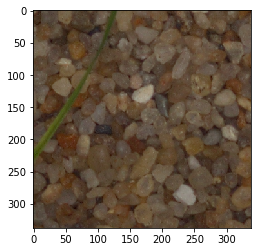

In [0]:
from keras.preprocessing import image
from sklearn.preprocessing import *
import matplotlib.pyplot as plt
import os, random
dir = "/content/test/"                # Randomly selecting a image for prediction from test 
filename = random.choice(os.listdir("/content/test//"))
filepath = os.path.join(dir, filename)
# filepath = "/content/test/4e18ab737.png"   # File path of the image you want to predict
test_image = image.load_img(filepath, target_size = (256, 256))  # Target size must be the
# input size of the image which is passed into the training.
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

#predict the result
result = model.predict(test_image)
import matplotlib.image as mpimg
testimage=mpimg.imread(filepath)
plt.imshow(testimage)
result_fin = enc.inverse_transform(result)
print(*result_fin,sep='')


In [0]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

NameError: ignored

#ResNet- 50

In [0]:
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAvgPool2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

def resnet_model(num_classes=None):

    model =  ResNet50(weights='imagenet', include_top=False,input_shape=(256,256,3))
#     model.layers.pop()
#     model.layers.pop()
#     model.layers.pop()

    model.outputs = [model.layers[-1].output]

    model.layers[-2].outbound_nodes= []
    x = BatchNormalization()(model.output)
    x=Conv2D(256, kernel_size=(2,2),strides=2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)    
    x=Conv2D(128, kernel_size=(3,3),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, kernel_size=(2,2),strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x=Conv2D(12, kernel_size=(2,2),strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
#     x=Flatten()(x)
#     x=Dense(num_classes, activation='softmax')(x)  
    x = GlobalAvgPool2D()(x)
    x = Activation('softmax')(x)

    model=Model(model.input,x)

    for layer in model.layers[-3:]:

        layer.trainable = False


    return model

In [0]:
from keras import backend as K
num_classes=12
model = resnet_model(num_classes)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.save('model1.h5')

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 4s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
____________________________________________

In [0]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
filepath="./weights.best1_{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoints = ModelCheckpoint(filepath, monitor='val_acc', 
                              verbose=1, save_best_only=True, mode='max')
filepath="./weights.last1_auto4.hdf5"
checkpoints_full = ModelCheckpoint(filepath, monitor='val_acc', 
                                 verbose=1, save_best_only=False, mode='max')

callbacks_list = [checkpoints, checkpoints_full]

#MODEL
# hist = model.fit_generator(generator.flow(x_train,y_train, batch_size=75), 
#                            epochs=35, validation_data=(x_test, y_test), 
#                            steps_per_epoch=x_train.shape[0], callbacks=callbacks_list)
history = model.fit(X_train,y_train,
          batch_size=64,
          epochs=10,
          verbose=1, shuffle=True, validation_data=(X_val,y_val),callbacks=callbacks_list)

Train on 3325 samples, validate on 713 samples
Epoch 1/10


ResourceExhaustedError: ignored

In [0]:
import matplotlib.pyplot as plt
epochs = 10
fig, ax = plt.subplots()  
ax.plot(np.arange(epochs), history.history['loss'], 'r')
ax.plot(np.arange(epochs), history.history['val_loss'], 'b')
ax.legend(['train', 'validation'], loc='upper left')
ax.set_xlabel('Iterations')  
ax.set_ylabel('Cost')  
ax.set_title('Cost vs. Training Epoch') 
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred)

In [0]:
score = model.evaluate(X_test, y_test, verbose=0, batch_size = None)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
from keras.models import *
model = load_model('model1.h5')
m = model.load_weights("weights.best1_05-0.73.hdf5")   # Call the last model weights best -- The 
#next argument is the accuracy of the model

In [0]:
from keras.preprocessing import image
from sklearn.preprocessing import *
import matplotlib.pyplot as plt
import os, random
dir = "/content/test/"                # Randomly selecting a image for prediction from test 
filename = random.choice(os.listdir("/content/test//"))
filepath = os.path.join(dir, filename)
# filepath = "/content/test/4e18ab737.png"   # File path of the image you want to predict
test_image = image.load_img(filepath, target_size = (256, 256))  # Target size must be the
# input size of the image which is passed into the training.
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

#predict the result
result = model.predict(test_image)
import matplotlib.image as mpimg
testimage=mpimg.imread(filepath)
print(filepath)
plt.imshow(testimage)
result_fin = enc.inverse_transform(result)
print(*result_fin,sep='')


# Inception V-3

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten
from keras import backend as K

# create the base pre-trained model
model = InceptionV3(weights='imagenet', include_top=False,input_shape=(256,256,3))
model.layers[-2].outbound_nodes= []
# add a global spatial average pooling layer
x = model.output

x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
predictions = Dense(12, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)
#model.summary()

# first: train only the top layers (which were randomly initialized)
# # i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers:
#     layer.trainable = False

# # compile the model (should be done *after* setting layers to non-trainable)
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy',fscore])

# # train the model on the new data for a few epochs
# model.fit(X_train,y_train, batch_size=64,epochs=3, verbose=1, shuffle=True, validation_data=(X_val,y_val))

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)
#model.summary()
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[-2:]:
   layer.trainable = False
# for layer in model.layers[250:]:
#    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.save("model2.h5")
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
filepath="./weights.best2_{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoints = ModelCheckpoint(filepath, monitor='val_acc', 
                              verbose=1, save_best_only=True, mode='max')
filepath="./weights.last2_auto4.hdf5"
checkpoints_full = ModelCheckpoint(filepath, monitor='val_acc', 
                                 verbose=1, save_best_only=False, mode='max')

callbacks_list = [checkpoints, checkpoints_full]



history = model.fit(X_train,y_train,batch_size=64, epochs=30,verbose=1, shuffle=True, validation_data=(X_val,y_val),callbacks=callbacks_list)

In [0]:
import matplotlib.pyplot as plt
epochs = 30
fig, ax = plt.subplots()  
ax.plot(np.arange(epochs), history.history['loss'], 'r')
ax.plot(np.arange(epochs), history.history['val_loss'], 'b')
ax.legend(['train', 'validation'], loc='upper left')
ax.set_xlabel('Iterations')  
ax.set_ylabel('Cost')  
ax.set_title('Cost vs. Training Epoch') 
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

In [0]:
score = model.evaluate(X_test, y_test, verbose=0, batch_size = None)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [0]:
from keras.preprocessing import image
from sklearn.preprocessing import *
import matplotlib.pyplot as plt
import os, random
dir = "/content/test/"                # Randomly selecting a image for prediction from test 
filename = random.choice(os.listdir("/content/test//"))
filepath = os.path.join(dir, filename)
# filepath = "/content/test/4e18ab737.png"   # File path of the image you want to predict
test_image = image.load_img(filepath, target_size = (256, 256))  # Target size must be the
# input size of the image which is passed into the training.
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

#predict the result
result = model.predict(test_image)
import matplotlib.image as mpimg
testimage=mpimg.imread(filepath)
plt.imshow(testimage)
result_fin = enc.inverse_transform(result)
print(*result_fin,sep='')


In [0]:
# To save the models and weight files into google buckets into a folder Model_dev
! gsutil -m cp -r w* m* gs://proobj/Model_dev/

# Prediction

In [0]:

## Downloading dataset from Buckets
!gsutil -m cp -r gs://proobj/t*.zip .
!unzip test.zip
!unzip train.zip

In [0]:
# Downloading models with weights from Buckets  0-VGG 1-RESENT50 2-Inception-v3
# Model_dev consists the model files for VGG16, RESNET50, INCEPTION-V3
# Note the last epoch number file is the best accuracy file
! gsutil -m cp -r  gs://proobj/Model_dev/ .

In [0]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob
import seaborn as sns


TRAin_DATA_FOLDER= "train"


images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAin_DATA_FOLDER):
    class_folder_path = os.path.join(TRAin_DATA_FOLDER, class_folder_name)
    class_label = class_folder_name
   
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missig value ignore it
          missing += 1
          continue
        images.append(image_bgr)
       
        classes.append(class_label)
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y = enc.fit_transform(classes)
y[0]

In [0]:
### PREDICTION FROM VGG 16 ####

from keras.models import *
model = load_model('./Model_dev/model.h5')
m = model.load_weights("./Model_dev/weights.best_10-0.92.hdf5")   # Call the last model weights best -- The 
#next argument is the accuracy of the model


In [0]:
### PREDICTION FROM RESNET 50 ###

from keras.models import *
model = load_model('./Model_dev/model1.h5')
m = model.load_weights("./Model_dev/weights.best1_05-0.73.hdf5")   # Call the last model weights best -- The 
#next argument is the accuracy of the model


In [0]:
### PREDICTION FROM INCEPTION ###
from keras.models import *
model = load_model('./Model_dev/model2.h5')
m = model.load_weights("./Model_dev/weights.best2_30-0.95.hdf5")   # Call the last model weights best -- The 
#next argument is the accuracy of the model


In [0]:
from keras.preprocessing import image
from sklearn.preprocessing import *
import matplotlib.pyplot as plt
import os, random
import numpy as np
dir = "/content/test/"                # Randomly selecting a image for prediction from test 
filename = random.choice(os.listdir("/content/test//"))
filepath = os.path.join(dir, filename)
# filepath = "/content/test/4e18ab737.png"   # File path of the image you want to predict
test_image = image.load_img(filepath, target_size = (256, 256))  # Target size must be the
# input size of the image which is passed into the training.
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

#predict the result
result = model1.predict(test_image)
import matplotlib.image as mpimg
testimage=mpimg.imread(filepath)
plt.imshow(testimage)
result_fin = enc.inverse_transform(result)
print(*result_fin,sep='')